In [1]:
from pathlib import Path
import json
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import torch
from torch.nn import ReLU, Sigmoid, MSELoss
from torch.utils.data import DataLoader
from MulticoreTSNE import MulticoreTSNE as TSNE
from functools import partial
import datashader as ds
import datashader.transfer_functions as dtf
from datashader.mpl_ext import dsshow
import pandas as pd

from py.datasets.euromds import CachedEUROMDS
from py.dec.torch.sdae import StackedDenoisingAutoEncoder
from py.dec.torch.dec import DEC
from py.dec.torch.utils import get_linears
from py.dec.torch.utils import cluster_accuracy

In [2]:
PATH_TO_DATA = Path('/home/relogu/Desktop/OneDrive/UNIBO/Magistrale/Federated Learning Project/data/euromds')
PATH_TO_MODELS = Path('/home/relogu/Desktop/OneDrive/UNIBO/Magistrale/Federated Learning Project/results')
filename = 'euromds_ae_dec_sgd' # 'euromds_ae_dec_sgd' # 'euromds_cl_best_modloss' # 'euromds_cl_best'
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda:0"
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)

Loading data

In [3]:
dataset = CachedEUROMDS(
        exclude_cols=['UTX', 'CSF3R', 'SETBP1', 'PPM1D'],
        groups=['Genetics', 'CNA'],
        path_to_data=PATH_TO_DATA,
        fill_nans=2044,
        get_hdp=True,
        get_outcomes=True,
        get_ids=True,
        verbose=False,
        device=DEVICE,
    )
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
)

Initialize TSDAE, getting reconstructed images.

/home/relogu/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


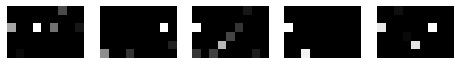

In [4]:
with open(PATH_TO_MODELS/filename/'config.json') as file:
    config = dict(json.load(file))
autoencoder = StackedDenoisingAutoEncoder(
    get_linears(config['linears'], dataset.n_features, config['f_dim']),
    activation=ReLU() if config['activation'] == 'relu' else Sigmoid(),
    final_activation=ReLU() if config['final_activation'] == 'relu' else Sigmoid(),
    dropout=config['dropout'],
    is_tied=True,
)
autoencoder.load_state_dict(torch.load(PATH_TO_MODELS/filename/'pretrain_ae'))
autoencoder.to(DEVICE)
r_data = []
for i, batch in enumerate(dataloader):
    with torch.no_grad():
        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
            batch, value = batch
        batch = batch.to(DEVICE, non_blocking=True)
        r_batch = autoencoder(batch)
        r_data.append(r_batch.cpu())
r_data = torch.cat(r_data).numpy()
fig, axs = plt.subplots(1, 5, figsize=(8, 8))
ids = [3,4,345,58,34]
axs = axs.flatten()
for i, ax in zip(ids, axs):
    ax.imshow(r_data[i].reshape((6,9)), interpolation='none', cmap='gray')
    ax.axis('off')
aa = [val.cpu().numpy() for _, val in autoencoder.state_dict().items()]
np.savez('pretrain_ae.npz', aa)

Initializing DEC model.

In [5]:
model = DEC(cluster_number=config['n_clusters'],
            hidden_dimension=config['f_dim'],
            encoder=autoencoder.encoder,
            alpha=config['alpha'])
model.to(DEVICE)
model.load_state_dict(torch.load(PATH_TO_MODELS/filename/'dec_model'))

<All keys matched successfully>

In [6]:
aa = [val.cpu().numpy() for _, val in model.state_dict().items()]
np.savez('dec_model.npz', aa)

Getting predictions from DEC model.

In [7]:
cl_recon = 0.0
criterion = MSELoss()
data = []
r_data = []
features = []
prob_labels = []
r_prob_labels = []
actual = []
model.eval()
autoencoder.eval()
for i, batch in enumerate(dataloader):
    with torch.no_grad():
        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
            batch, value = batch
            actual.append(value.cpu())
            data.append(batch.cpu())
        batch = batch.to(DEVICE, non_blocking=True)
        r_batch = autoencoder(batch)
        f_batch = autoencoder.encoder(batch)
        features.append(f_batch.cpu())
        r_data.append(r_batch.cpu())
        loss = criterion(r_batch, batch)
        cl_recon += loss.cpu().numpy()
        prob_labels.append(model(batch).cpu())
        r_prob_labels.append(model(r_batch).cpu())
        
cl_recon = (cl_recon / (i+1))
predicted = torch.cat(prob_labels).max(1)[1]
r_predicted = torch.cat(r_prob_labels).max(1)[1]
actual = torch.cat(actual).long()
data = torch.cat(data).numpy()
r_data = torch.cat(r_data).numpy()
features = torch.cat(features).numpy()
# delta_label = (
#     float((predicted != predicted_previous).float().sum().item())
#     / predicted_previous.shape[0]
# )

cos_sil_score = silhouette_score(
    X=data,
    labels=predicted,
    metric='cosine')

eucl_sil_score = silhouette_score(
    X=features,
    labels=predicted,
    metric='euclidean')

data_calinski_harabasz = calinski_harabasz_score(
    X=data,
    labels=predicted)

feat_calinski_harabasz = calinski_harabasz_score(
    X=features,
    labels=predicted)

reassignment, accuracy = cluster_accuracy(predicted.numpy(), actual.numpy())
r_reassignment, cycle_accuracy = cluster_accuracy(r_predicted.numpy(), predicted.numpy())
predicted_reassigned = [reassignment[item] for item in predicted.numpy()]

Computing metrics from HDP labels.

In [8]:
## HDP metrics
cos_sil_score = silhouette_score(
    X=data,
    labels=actual.numpy(),
    metric='cosine')

eucl_sil_score = silhouette_score(
    X=features,
    labels=actual.numpy(),
    metric='euclidean')

data_calinski_harabasz = calinski_harabasz_score(
    X=data,
    labels=actual.numpy())

feat_calinski_harabasz = calinski_harabasz_score(
    X=features,
    labels=actual.numpy())
pd.DataFrame(
    data=[[cos_sil_score,eucl_sil_score,np.log(data_calinski_harabasz),np.log(feat_calinski_harabasz)]],
    columns=['cos_sil_score','eucl_sil_score','data_calinski_harabasz','feat_calinski_harabasz']).to_csv('hdp_metrics.csv')

Plotting survival curves for the following outcomes.

outcome[:,0] --> "Evolution to acute leukemia  adjusted censored at transplantation (yes/no)","Outcome Data"
outcome[:,1] --> "LFS adjusted  censored at transplantation (months)","Outcome Data"
outcome[:,2] --> "Dead/Alive adjusted censored at transplantation","Outcome Data"
outcome[:,3] --> "OS adjusted  censored at transplantation (months)","Outcome Data"
outcome[:,4] --> "Dead or AML/Alive with noAML adjusted censored at transplantation","Outcome Data"
outcome[:,5] --> "EFS adjusted  censored at transplantation (months)","Outcome Data"

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


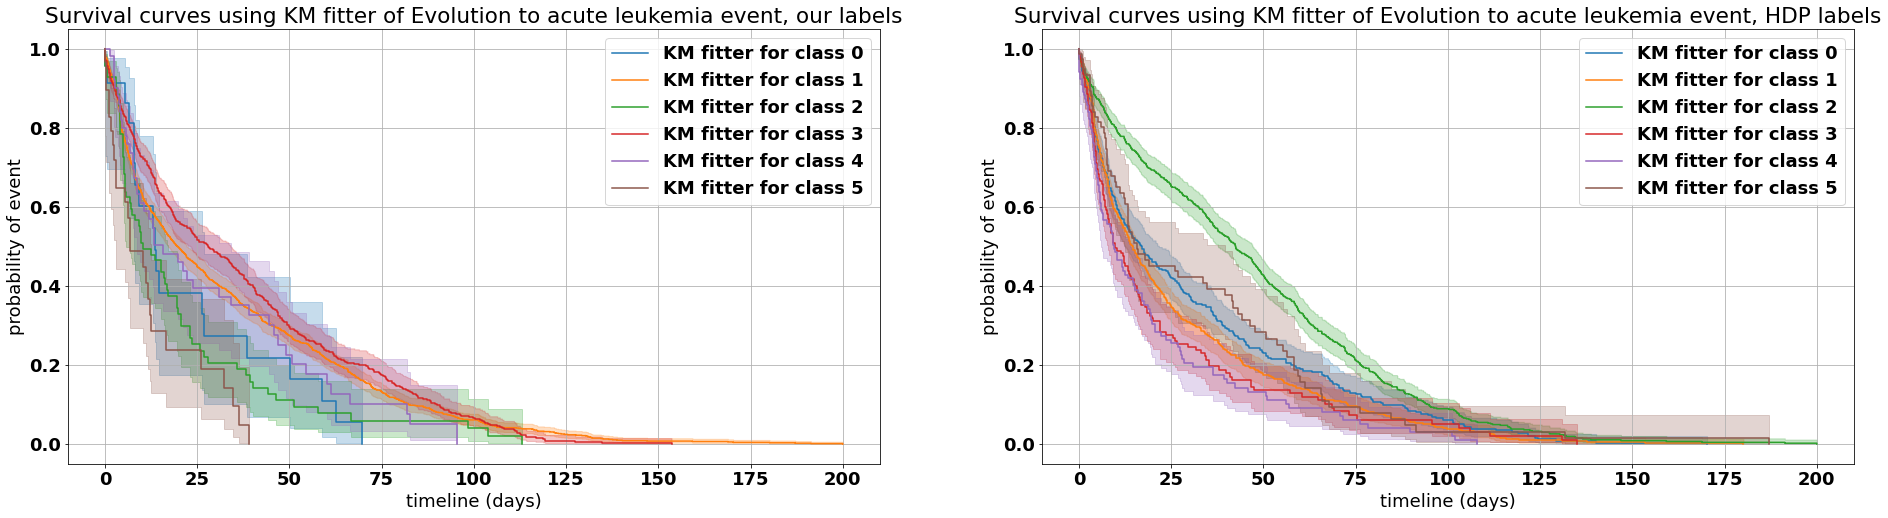

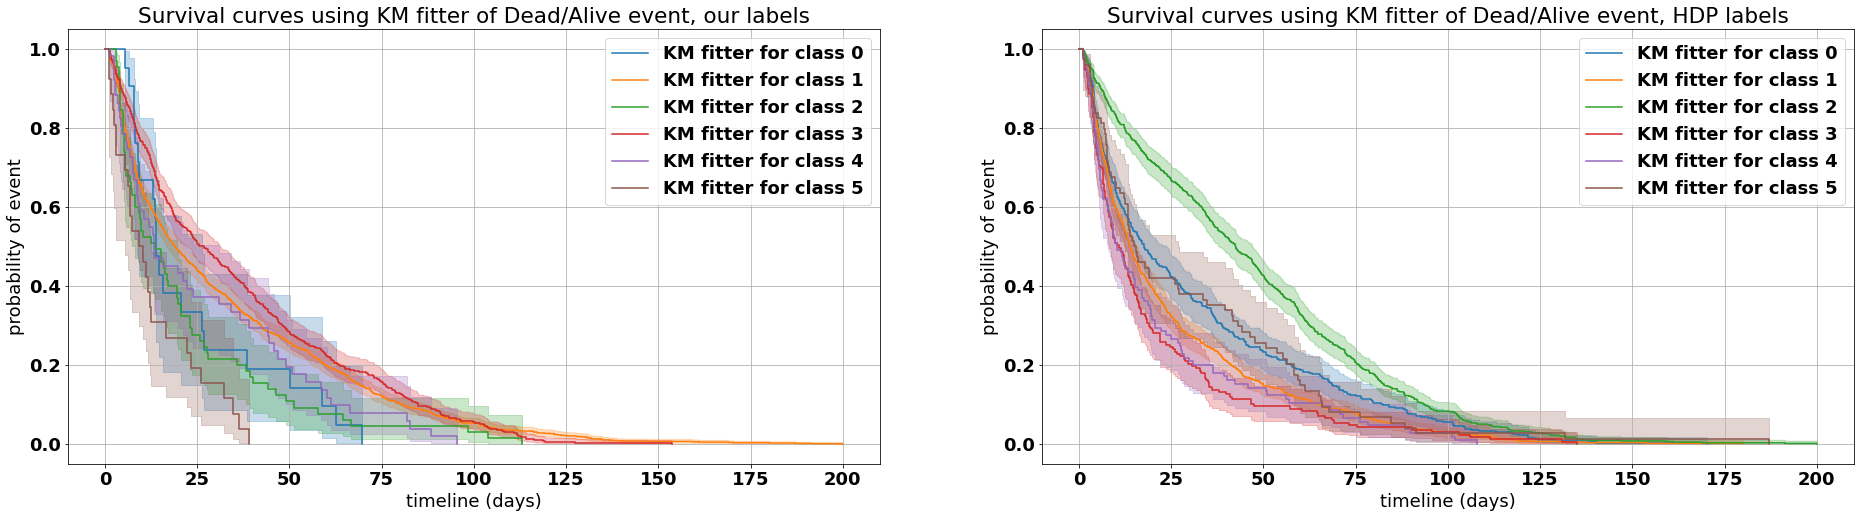

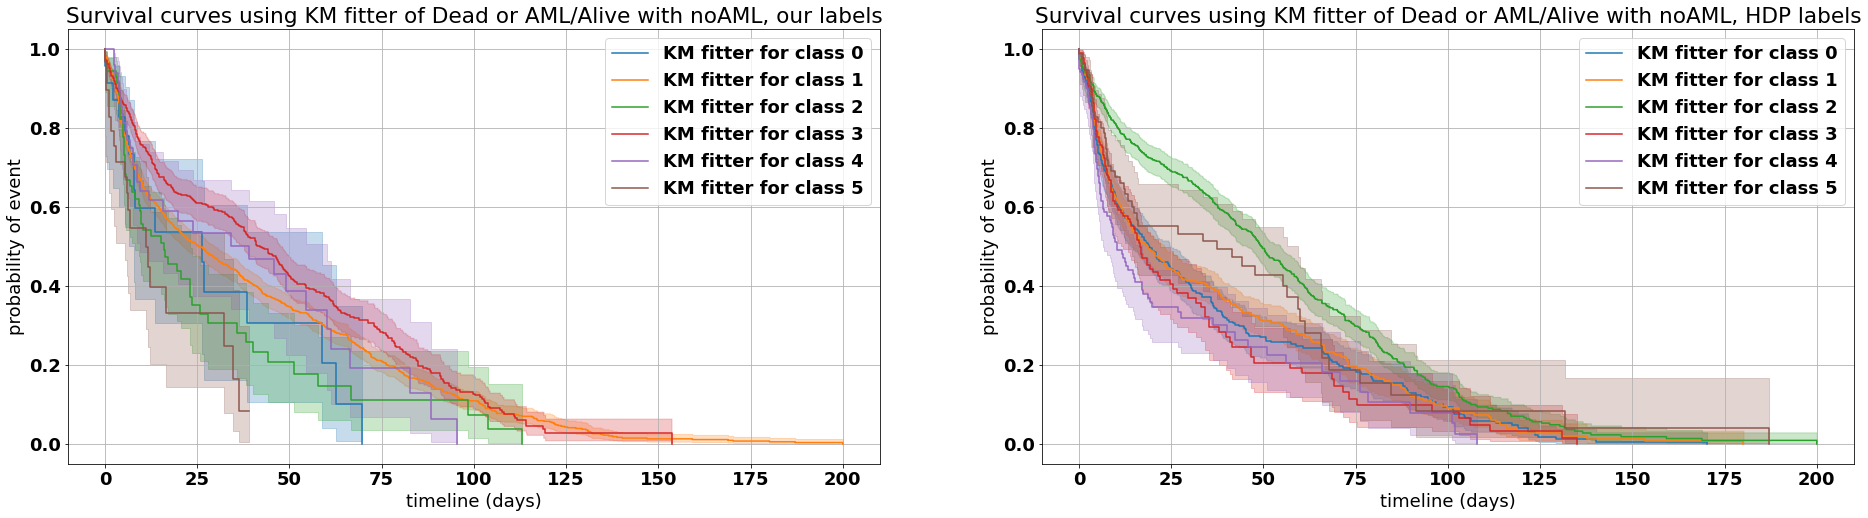

In [9]:
for i, event in enumerate(['Evolution to acute leukemia event', 'Dead/Alive event', 'Dead or AML/Alive with noAML']):
    fig, axes = plt.subplots(1, 2, figsize=(32, 8))
    axes = axes.flatten()
    events = dataset.outcomes[:, i]
    times = dataset.outcomes[:, int(2*i+1)]
    show_ci = True
    for label in np.unique(predicted_reassigned):
        idx = (predicted_reassigned == label)
        unique, counts = np.unique(idx, return_counts=True)
        ax = axes[0]
        # if counts[unique==True] > 20:
        fitter = KaplanMeierFitter()
        fitter.fit(times[idx], events[idx], label='KM fitter for class {}'.format(label))
        plot = fitter.plot_survival_function(ax=ax, ci_show=show_ci, ci_force_lines=False, show_censors=False)
        ax.set_ylabel('probability of event')
        ax.set_xlabel('timeline (days)')
        ax.grid()
        ax.set_title('Survival curves using KM fitter of {}, our labels'.format(event))

    # add titles

    for label in np.unique(actual):
        idx = (actual == label)
        unique, counts = np.unique(idx, return_counts=True)
        ax = axes[1]
        # if counts[unique==True] > 20:
        fitter = KaplanMeierFitter()
        fitter.fit(times[idx], events[idx], label='KM fitter for class {}'.format(label))
        fitter.plot_survival_function(ax=ax, ci_show=show_ci, ci_force_lines=False, show_censors=False)
        ax.set_ylabel('probability of event')
        ax.set_xlabel('timeline (days)')
        ax.grid()
        ax.set_title('Survival curves using KM fitter of {}, HDP labels'.format(event))
    plt.savefig('surv_curves_{}.png'.format(i))

Get t-SNE representation for the feature space after clustering step is finished.

In [11]:
reassignment, accuracy = cluster_accuracy(actual.numpy(), predicted.numpy())
predicted_reassigned = [reassignment[item] for item in predicted.numpy()]
delta = 1.0

tsne = TSNE(
    n_components=2,
    n_jobs=-1,
    random_state=51550
).fit_transform(features)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


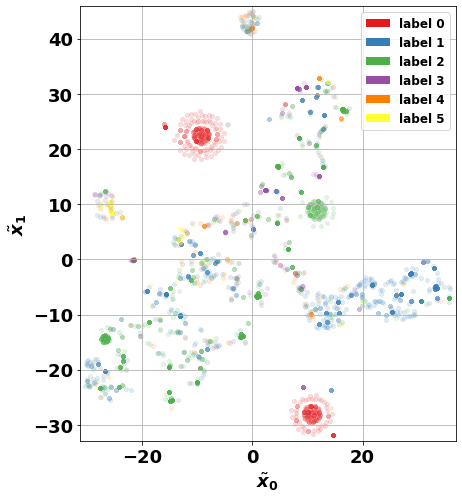

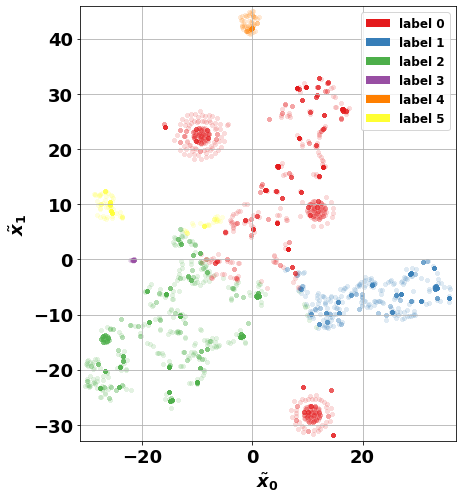

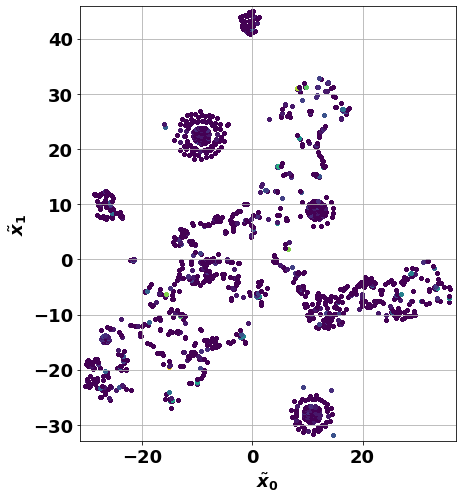

In [12]:
points = pd.DataFrame(tsne[:len(features)], columns=['x0', 'x1'])
points['y'] = ['label {}'.format(l) for l in actual.numpy()]
points['y'] = points['y'].astype("category")

fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = 'tab10'
agg = ds.count_cat('y')

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')
plt.legend(handles=artist.get_legend_elements(), prop={'size': 12}, loc='upper right')

plt.savefig('cluster_tsne_space_euromds_cl_best_actual.png')
plt.show()

points['y'] = ['label {}'.format(l) for l in predicted_reassigned]
points['y'] = points['y'].astype("category")

fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = 'tab10'
agg = ds.count_cat('y')

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')
plt.legend(handles=artist.get_legend_elements(), prop={'size': 12}, loc='upper right')

plt.savefig('cluster_tsne_space_euromds_cl_best_predicted.png')
plt.show()


fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = None
agg = ds.count()

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')

plt.savefig('cluster_tsne_space_euromds_cl_best_nolbl.png')
plt.show()

Get t-SNE representation for the feature space after training TSDAE.

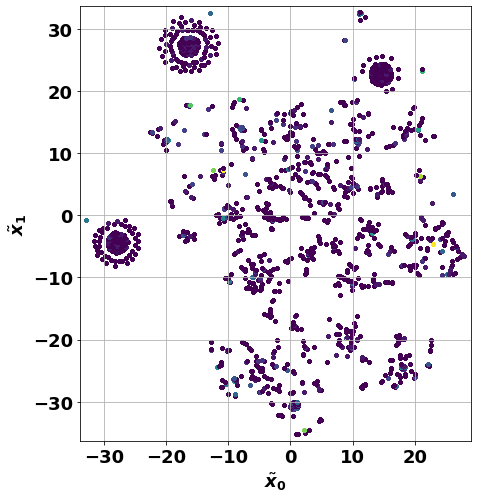

In [13]:
autoencoder.load_state_dict(torch.load(PATH_TO_MODELS/filename/'pretrain_ae'))

features = []
actual = []
autoencoder.eval()
for i, batch in enumerate(dataloader):
    with torch.no_grad():
        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
            batch, value = batch
            actual.append(value.cpu())
        batch = batch.to(DEVICE, non_blocking=True)
        f_batch = autoencoder.encoder(batch)
        features.append(f_batch.cpu())
actual = torch.cat(actual).long()
features = torch.cat(features).numpy()

delta = 1.0

tsne = TSNE(
    n_components=2,
    n_jobs=-1,
    random_state=51550
).fit_transform(features)


points = pd.DataFrame(tsne[:len(features)], columns=['x0', 'x1'])

fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = None

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')

plt.savefig('ae_tsne_space_euromds_cl_best.png')
plt.show()

Get t-SNE representation for the feature space after training TSDAE, but using a modified loss.

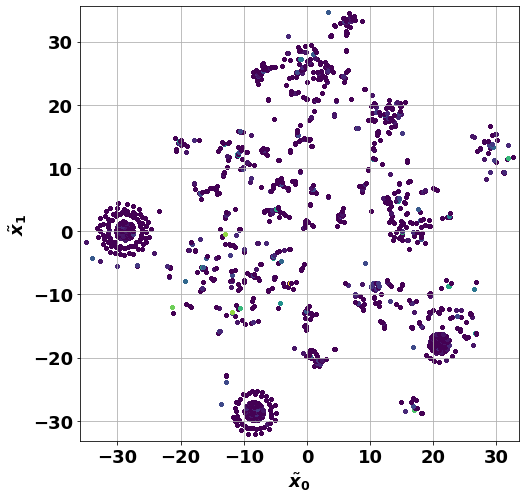

In [14]:
filename = 'euromds_cl_best_modloss'
autoencoder.load_state_dict(torch.load(PATH_TO_MODELS/filename/'pretrain_ae'))

features = []
actual = []
autoencoder.eval()
for i, batch in enumerate(dataloader):
    with torch.no_grad():
        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
            batch, value = batch
            actual.append(value.cpu())
        batch = batch.to(DEVICE, non_blocking=True)
        f_batch = autoencoder.encoder(batch)
        features.append(f_batch.cpu())
actual = torch.cat(actual).long()
features = torch.cat(features).numpy()

delta = 1.0

tsne = TSNE(
    n_components=2,
    n_jobs=-1,
    random_state=51550
).fit_transform(features)


points = pd.DataFrame(tsne[:len(features)], columns=['x0', 'x1'])

fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = None

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')

plt.savefig('ae_tsne_space_euromds_cl_best.png')
plt.show()